In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler


In [44]:
df = pd.read_csv('Data/features_after_augmentation.csv')
X = df.drop(columns='label')
y = df['label']
X.shape, y.value_counts()

((7200, 36),
 calm        960
 happy       960
 sad         960
 angry       960
 fear        960
 disgust     960
 surprise    960
 neutral     480
 Name: label, dtype: int64)

In [45]:

oversampler = RandomOverSampler(sampling_strategy={'neutral': int(y.value_counts().max())}, random_state=42)


X_resampled, y_resampled = oversampler.fit_resample(X, y)


df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='label')], axis=1)

In [46]:
X = df_resampled.drop(columns='label')
y = df_resampled['label']
X.shape, y.value_counts()

((7680, 36),
 neutral     960
 calm        960
 happy       960
 sad         960
 angry       960
 fear        960
 disgust     960
 surprise    960
 Name: label, dtype: int64)

In [32]:

le = LabelEncoder()
y_encoded = le.fit_transform(y)


y_one_hot = tf.keras.utils.to_categorical(y_encoded, num_classes=len(np.unique(y_encoded)))
y_one_hot

<IPython.core.display.Javascript object>

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [33]:

X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


model = Sequential()
model.add(Dense(256, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  


custom_optimizer = Adam(learning_rate=0.0001)  
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train_scaled, y_train_encoded, epochs=100, batch_size=30, validation_split=0.2, verbose=1)

Epoch 1/100
164/164 [==============================] - 1s 3ms/step - loss: 2.0310 - accuracy: 0.1866 - val_loss: 1.9416 - val_accuracy: 0.2620
Epoch 2/100
164/164 [==============================] - 0s 2ms/step - loss: 1.8821 - accuracy: 0.2765 - val_loss: 1.7962 - val_accuracy: 0.3271
Epoch 3/100
164/164 [==============================] - 0s 2ms/step - loss: 1.7559 - accuracy: 0.3392 - val_loss: 1.6870 - val_accuracy: 0.3735
Epoch 4/100
164/164 [==============================] - 0s 2ms/step - loss: 1.6651 - accuracy: 0.3915 - val_loss: 1.6140 - val_accuracy: 0.3963
Epoch 5/100
164/164 [==============================] - 0s 2ms/step - loss: 1.5959 - accuracy: 0.4157 - val_loss: 1.5580 - val_accuracy: 0.4264
Epoch 6/100
164/164 [==============================] - 0s 2ms/step - loss: 1.5394 - accuracy: 0.4403 - val_loss: 1.5266 - val_accuracy: 0.4451
Epoch 7/100
164/164 [==============================] - 0s 2ms/step - loss: 1.4898 - accuracy: 0.4553 - val_loss: 1.4907 - val_accuracy: 0.4378

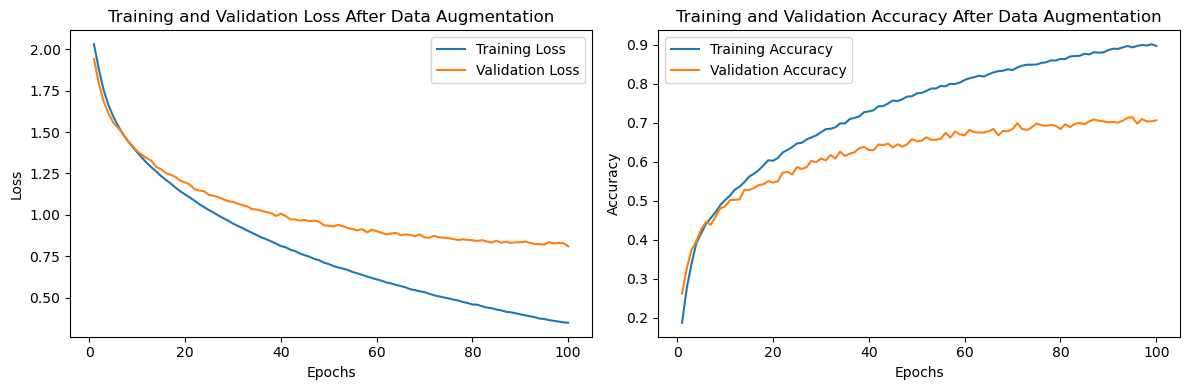

In [42]:

epochs = np.arange(1, len(history.history['loss']) + 1)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(epochs, history.history['loss'], label='Training Loss')
ax[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Training and Validation Loss After Data Augmentation')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, history.history['accuracy'], label='Training Accuracy')
ax[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy After Data Augmentation')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

 1/48 [..............................] - ETA: 0s

48/48 [==============================] - 0s 2ms/step


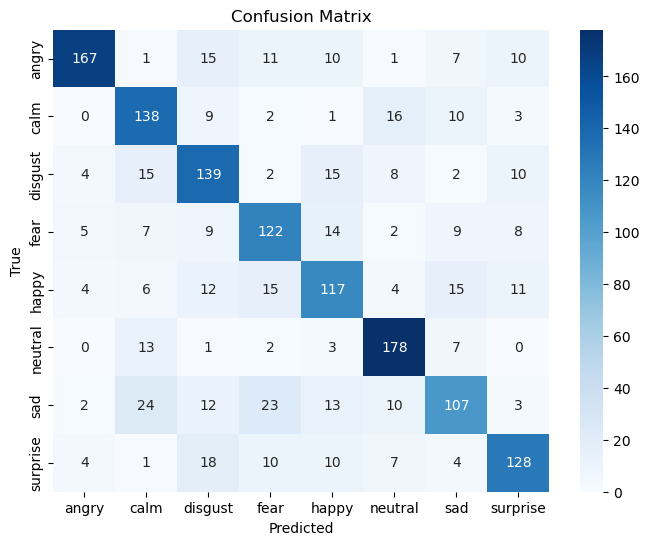

In [39]:

y_pred_encoded = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_encoded, axis=1)
y_true_classes = np.argmax(np.array(y_test_encoded), axis=1)


conf_mat = confusion_matrix(y_true_classes, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [36]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_classes.flatten()
df['Actual Labels'] = y_true_classes.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,4,7
1,2,7
2,4,4
3,7,7
4,2,2
5,7,7
6,3,3
7,3,3
8,5,1
9,3,3


In [40]:
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82       222
           1       0.67      0.77      0.72       179
           2       0.65      0.71      0.68       195
           3       0.65      0.69      0.67       176
           4       0.64      0.64      0.64       184
           5       0.79      0.87      0.83       204
           6       0.66      0.55      0.60       194
           7       0.74      0.70      0.72       182

    accuracy                           0.71      1536
   macro avg       0.71      0.71      0.71      1536
weighted avg       0.72      0.71      0.71      1536

